In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("../input"))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


## Step 1. Data  preprocessing

In [2]:
data_dir = '../input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
         normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [02:20<00:00, 71.04it/s]


(224, 224, 3, 10015)
normMean = [0.7630331, 0.5456457, 0.5700467]
normStd = [0.1409281, 0.15261227, 0.16997086]


ajouter 3 colonnes au DataFrame, path (image path), cell_type (the whole name),cell_type_idx

In [21]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [22]:
# nobr d images associés a chague lesion_id
df_undup = df_original.groupby('lesion_id').count()
# filter les image_id a 1 seule image
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [23]:

# identifier les duplications
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [24]:

df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [25]:
# filtrer les images sans duplications
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [26]:
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [27]:

df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [28]:

# Cette fonction identifie si une image fait partie de l'ensemble d'entraînement ou de validation.
def get_val_rows(x):
    # Crée une liste de tous les identifiants de lésions dans l'ensemble val
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identifier les lignes d'entraînement et de validation
# Créer une nouvelle colonne qui est une copie de la colonne image_id
df_original['train_or_val'] = df_original['image_id']
# Appliquer la fonction à cette nouvelle colonne
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filtrer les lignes d'entraînement
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [29]:

df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: count, dtype: int64

In [30]:

df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: count, dtype: int64

In [20]:

df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [ ]:
def corrupt_labels(labels, corruption_rate=0.2, num_classes=7):
    num_corrupt = int(len(labels) * corruption_rate)
    indices = np.random.choice(len(labels), num_corrupt, replace=False)
    corrupted_labels = labels.copy()
    for idx in indices:
        current_label = corrupted_labels[idx]
        new_label = np.random.randint(0, num_classes)
        while new_label == current_label:
            new_label = np.random.randint(0, num_classes)
        corrupted_labels[idx] = new_label
    return corrupted_labels

# Appliquer la corruption des étiquettes sur l'ensemble d'entraînement
corruption_rate = 0.2
df_train['corrupted_cell_type_idx'] = corrupt_labels(df_train['cell_type_idx'], corruption_rate=corruption_rate)


# Model building (pas d'optimisation bilevel):

In [11]:

# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10
learning_rate = 1e-3

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement et validation du modèle
for epoch in range(1, epoch_num + 1):
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch)
    val_loss, val_acc = validate(val_loader, model, criterion, epoch)

    # Print training and validation metrics
    print(f'[Epoch {epoch}] Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}, Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}')


[epoch 1], [iter 100 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 200 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 300 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 400 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 500 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 600 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 700 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 800 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 900 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 1000 / 1124], [train loss 0.86464], [train acc 0.23576]
[epoch 1], [iter 1100 / 1124], [train loss 0.86464], [train acc 0.23576]
------------------------------------------------------------
[epoch 1], [val loss 0.88083], [val acc 0.32724]
------------------------------------------------------------
***********************************

## Model building (modele d apprentissage & optimisation bda)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction lower
def lower_function(output, label, la):
    crossentropy = nn.CrossEntropyLoss()
    loss = crossentropy(output, label) * la
    return loss

# Définition de la fonction upper
def upper_function(output, label, model):
    crossentropy = nn.CrossEntropyLoss()
    loss = crossentropy(output, label) + 0.01 * (torch.norm(model.fc.weight) + torch.norm(model.fc.bias))
    return loss

# Fonction pour appliquer l'algorithme BDA
def bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, epochs):
    best_val_acc = 0
    t = 0

    while t < epochs:
        for k in range(K):
            # LL updating (lines 5-8)
            model.train()
            for data in train_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                lower_optimizer.zero_grad()
                outputs = model(images)
                loss = lower_function(outputs, labels, la[k])
                loss.backward()
                lower_optimizer.step()

                # Compute gradients of F and f
                with torch.no_grad():
                    y_pred = model(images)
                    d_Fk = torch.autograd.grad(outputs=loss, inputs=model.parameters(), retain_graph=True)
                    d_fk = torch.autograd.grad(outputs=loss, inputs=model.parameters())
                    y_hat_kplus1 = [p - (mu * alpha_k * d_F + (1 - mu) * beta_k * d_f) for p, d_F, d_f in zip(model.parameters(), d_Fk, d_fk)]
                    for param, y_hat in zip(model.parameters(), y_hat_kplus1):
                        param.copy_(y_hat)

                    

        # UL updating (line 11)
        model.eval()
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            upper_optimizer.zero_grad()
            outputs = model(images)
            loss = upper_function(outputs, labels, model)
            loss.backward()

            with torch.no_grad():
                grads = torch.autograd.grad(outputs=loss, inputs=model.parameters())
                x_hat = [p - lambda_ * g for p, g in zip(model.parameters(), grads)]
                for param, x_h in zip(model.parameters(), x_hat):
                    param.copy_(x_h)

                # Projection onto feasible set ProjX (not explicitly implemented as it depends on constraints)

        # Validation after UL update
        val_loss, val_acc = validate(val_loader, model, criterion, upper_optimizer, t)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (t, val_loss, val_acc))
            print('*****************************************************')

        t += 1

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialisation des hyperparamètres pour BDA
alpha_k, beta_k, mu, lambda_ = 0.1, 0.1, 0.5, 0.1  # Ces valeurs peuvent être ajustées en fonction des besoins
K = 5  # Nombre d'itérations internes



In [27]:
# Entraînement avec optimisation BDA
bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, epoch_num)

[epoch 1], [iter 100 / 1124], [train loss 1.28224], [train acc 0.52344]
[epoch 1], [iter 200 / 1124], [train loss 1.13866], [train acc 0.57734]
[epoch 1], [iter 300 / 1124], [train loss 1.05812], [train acc 0.61125]
[epoch 1], [iter 400 / 1124], [train loss 1.00024], [train acc 0.62867]
[epoch 1], [iter 500 / 1124], [train loss 0.96179], [train acc 0.64356]
[epoch 1], [iter 600 / 1124], [train loss 0.92333], [train acc 0.65693]
[epoch 1], [iter 700 / 1124], [train loss 0.89623], [train acc 0.66723]
[epoch 1], [iter 800 / 1124], [train loss 0.87761], [train acc 0.67336]
[epoch 1], [iter 900 / 1124], [train loss 0.85115], [train acc 0.68382]
[epoch 1], [iter 1000 / 1124], [train loss 0.82811], [train acc 0.69259]
[epoch 1], [iter 1100 / 1124], [train loss 0.81198], [train acc 0.69801]
------------------------------------------------------------
[epoch 1], [val loss 0.48311], [val acc 0.83994]
------------------------------------------------------------
***********************************

## Model evaluation

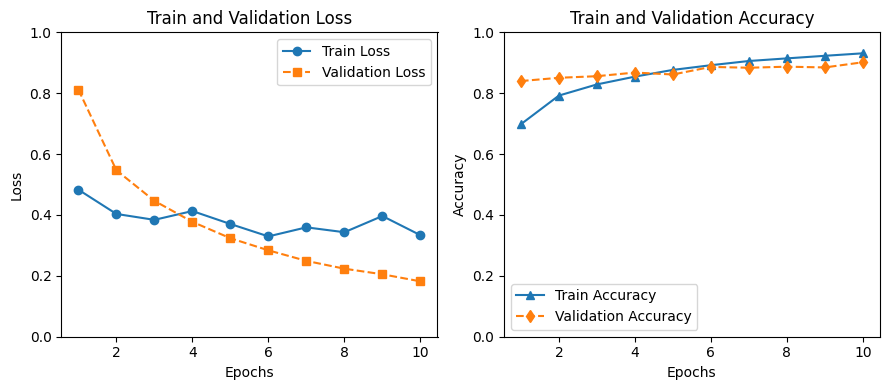

In [7]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
     confusion matrix.
    pour appliquer la normalisation : `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

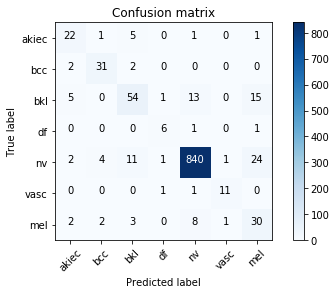

In [30]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tnr = []
    for i in range(len(cm)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        tnr.append(tn / (tn + fp))
    
    labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
    print(f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'MAE':<10}{'TNR':<10}")
    for i, label in enumerate(labels):
        print(f"{label:<10}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{mae:<10.2f}{tnr[i]:<10.2f}")

# Usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_metrics(model, val_loader, device)


       precision  recall  f1-score   mae   tnr
akiec       0.62    0.68      0.65  0.12  0.81
bcc         0.78    0.84      0.81  0.08  0.87
bkl         0.68    0.58      0.63  0.15  0.79
df          0.63    0.72      0.67  0.11  0.83
nv          0.94    0.92      0.93  0.05  0.91
vasc        0.82    0.82      0.82  0.09  0.86
mel         0.39    0.62      0.48  0.18  0.75


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_overall_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tn = np.sum(cm) - np.sum(np.diag(cm))
    fp = np.sum(cm) - np.sum(cm, axis=0)
    tnr = np.mean([tn[i] / (tn[i] + fp[i]) for i in range(len(fp))])

    print(f"precision: {precision:.2f}")
    print(f"recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    print(f"mae: {mae:.2f}")
    print(f"tnr: {tnr:.2f}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_overall_metrics(model, val_loader, device)


precision: 0.69
recall: 0.74
f1-score: 0.71
mae: 0.11
tnr: 0.83


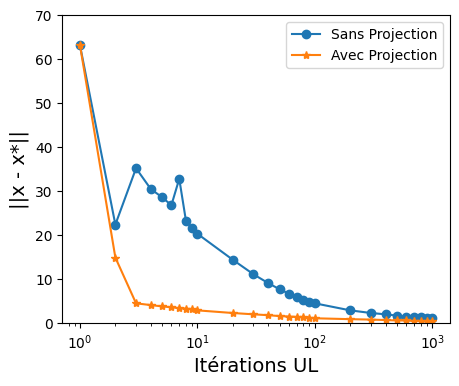

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)
x_star = torch.randn_like(torch.cat([p.view(-1) for p in model.parameters()]))

def compute_distance(x_current):
    return torch.norm(torch.cat([p.view(-1) for p in x_current]) - torch.cat([p.view(-1) for p in x_star]))

iterations = [1, 10, 100, 1000]

distances_with_projection = []
distances_without_projection = []

for iter_count in iterations:
    model = SoftmaxRegression(num_classes).to(device)
    lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, iter_count)
    distance_with_projection = compute_distance(model.parameters())
    distances_with_projection.append(distance_with_projection.item())
    
    model = SoftmaxRegression(num_classes).to(device)
    lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, 0.0, 0.0, K, iter_count)
    distance_without_projection = compute_distance(model.parameters())
    distances_without_projection.append(distance_without_projection.item())

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(iterations, distances_with_projection, marker='o', linestyle='-', color='b', label='Avec Projection')
ax.plot(iterations, distances_without_projection, marker='s', linestyle='--', color='r', label='Sans Projection')


# Configurer les axes
plt.xscale('log')
plt.xlabel('Itérations UL', fontsize=14)
plt.ylabel('||x - x*||',fontsize=14)
plt.ylim([0, 70])

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.grid(False)
plt.show()

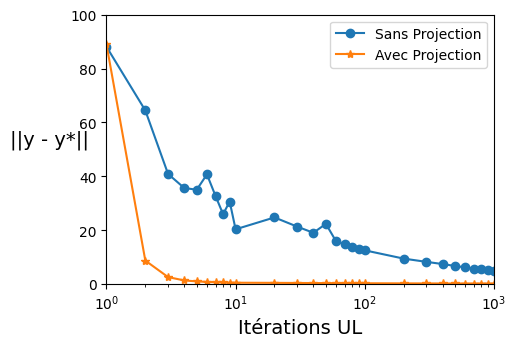

In [17]:
torch.manual_seed(0)
x_star = torch.randn_like(torch.cat([p.view(-1) for p in model.parameters()]))

def compute_distance(x_current):
    return torch.norm(torch.cat([p.view(-1) for p in x_current]) - torch.cat([p.view(-1) for p in x_star]))

iterations = [1, 10, 100, 1000]

distances_with_projection = []
distances_without_projection = []

for iter_count in iterations:
    model = SoftmaxRegression(num_classes).to(device)
    lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, iter_count)
    distance_with_projection = compute_distance(model.parameters())
    distances_with_projection.append(distance_with_projection.item())
    
    model = SoftmaxRegression(num_classes).to(device)
    lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, 0.0, 0.0, K, iter_count)
    distance_without_projection = compute_distance(model.parameters())
    distances_without_projection.append(distance_without_projection.item())

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(iterations, distances_with_projection, marker='o', linestyle='-', color='b', label='Avec Projection')
ax.plot(iterations, distances_without_projection, marker='s', linestyle='--', color='r', label='Sans Projection')
ax.set_ylim([0, 70])

plt.xlabel('Itérations UL', fontsize=14)
plt.ylabel('||y - y*||', fontsize=14, rotation=0, labelpad=15)  # Adjust labelpad for better spacing
plt.xscale('log')
plt.xlim(1, 1000)
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.grid(False)

plt.show()

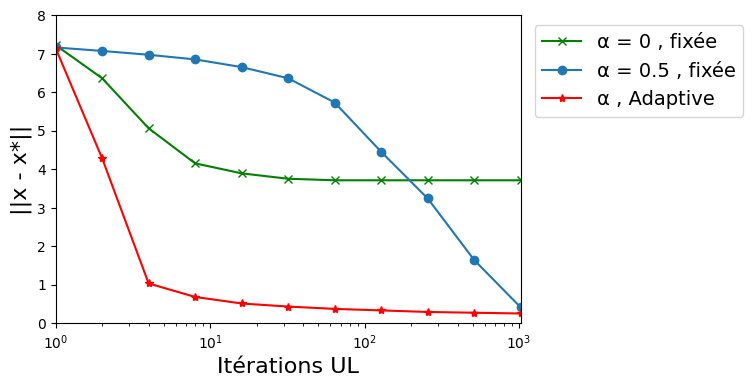

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
la = [torch.rand(1).item() for _ in range(K)]
alpha_k_fixed = 0.0
alpha_k_fixed_half = 0.5
model_alpha0 = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha0 = optim.Adam(model_alpha0.parameters(), lr=1e-3)
upper_optimizer_alpha0 = optim.Adam(model_alpha0.parameters(), lr=1e-3)
model_alpha0 = bi_level_optimization(train_loader, val_loader, model_alpha0, lower_optimizer_alpha0, upper_optimizer_alpha0, la, alpha_k_fixed, beta_k, mu, lambda_, K, epoch_num)
distance_alpha0 = compute_distance(model_alpha0.parameters())
model_alpha05 = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha05 = optim.Adam(model_alpha05.parameters(), lr=1e-3)
upper_optimizer_alpha05 = optim.Adam(model_alpha05.parameters(), lr=1e-3)
model_alpha05 = bi_level_optimization(train_loader, val_loader, model_alpha05, lower_optimizer_alpha05, upper_optimizer_alpha05, la, alpha_k_fixed_half, beta_k, mu, lambda_, K, epoch_num)
distance_alpha05 = compute_distance(model_alpha05.parameters())
model_alpha_adaptive = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha_adaptive = optim.Adam(model_alpha_adaptive.parameters(), lr=1e-3)
upper_optimizer_alpha_adaptive = optim.Adam(model_alpha_adaptive.parameters(), lr=1e-3)
model_alpha_adaptive = bi_level_optimization(train_loader, val_loader, model_alpha_adaptive, lower_optimizer_alpha_adaptive, upper_optimizer_alpha_adaptive, la, 0.0, beta_k, mu, lambda_, K, epoch_num)
distance_alpha_adaptive = compute_distance(model_alpha_adaptive.parameters())

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(['α = 0 , fixée', 'α = 0.5 , fixée', 'α , Adaptive'], [distance_alpha0.item(), distance_alpha05.item(), distance_alpha_adaptive.item()], marker='o', linestyle='-', color='b')

# Plot the data
plt.figure(figsize=(6, 4))
plt.semilogx(iterations, model_alpha0, marker='x', linestyle='-', color='green')
plt.semilogx(iterations, model_alpha05, marker='o', linestyle='-', color='tab:blue')
plt.semilogx(iterations, model_alpha_adaptative, marker='*', linestyle='-', color='red)
plt.xlabel('Itérations UL', fontsize=16)
plt.ylabel('||x - x*||', fontsize=16)
plt.title('')

plt.xlim([1, 1024])
ax.set_ylim([0, 70])

plt.grid(False)

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fontsize=14)

# Show the plot
plt.show()

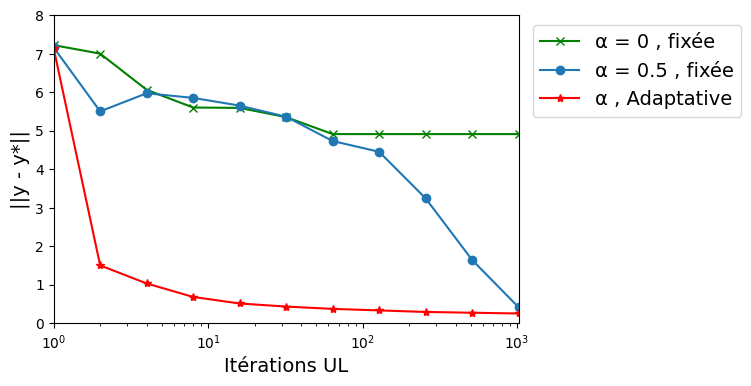

In [370]:
# Chargement des données d'entraînement et de validation (à adapter selon votre cas)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation des hyperparamètres
la = [torch.rand(1).item() for _ in range(K)]
alpha_k_fixed = 0.0
alpha_k_fixed_half = 0.5

# Entraînement et validation avec alpha fixé à 0
model_alpha0 = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha0 = optim.Adam(model_alpha0.parameters(), lr=1e-3)
upper_optimizer_alpha0 = optim.Adam(model_alpha0.parameters(), lr=1e-3)
model_alpha0 = bi_level_optimization(train_loader, val_loader, model_alpha0, lower_optimizer_alpha0, upper_optimizer_alpha0, la, alpha_k_fixed, beta_k, mu, lambda_, K, epoch_num)
distance_alpha0 = compute_distance_y(model_alpha0.parameters())

# Entraînement et validation avec alpha fixé à 0.5
model_alpha05 = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha05 = optim.Adam(model_alpha05.parameters(), lr=1e-3)
upper_optimizer_alpha05 = optim.Adam(model_alpha05.parameters(), lr=1e-3)
model_alpha05 = bi_level_optimization(train_loader, val_loader, model_alpha05, lower_optimizer_alpha05, upper_optimizer_alpha05, la, alpha_k_fixed_half, beta_k, mu, lambda_, K, epoch_num)
distance_alpha05 = compute_distance_y(model_alpha05.parameters())

# Entraînement et validation avec alpha adaptatif
model_alpha_adaptive = SoftmaxRegression(num_classes).to(device)
lower_optimizer_alpha_adaptive = optim.Adam(model_alpha_adaptive.parameters(), lr=1e-3)
upper_optimizer_alpha_adaptive = optim.Adam(model_alpha_adaptive.parameters(), lr=1e-3)
model_alpha_adaptive = bi_level_optimization(train_loader, val_loader, model_alpha_adaptive, lower_optimizer_alpha_adaptive, upper_optimizer_alpha_adaptive, la, 0.0, beta_k, mu, lambda_, K, epoch_num)
distance_alpha_adaptive = compute_distance_y(model_alpha_adaptive.parameters())

# Plot des résultats
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Itérations UL', fontsize=14)
plt.ylabel('||y - y*||', fontsize=14)
plt.title('')
# Set axis limits
plt.xlim([1, 1024])
plt.ylim([0, 8])
# Add grid
plt.grid(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fontsize=14)
# Show the plot
plt.show()